In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, VotingClassifier)
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split, KFold

In [153]:
"""
Checks which variables are most important for making it to 5 years
"""

df = pd.read_csv('C:/Users/cat_w/Documents/Second Year/QSAO/project/newRookies2000-2014.csv')

#mapping of teams by division
ALE = ["Rays", "Blue Jays", "Yankees", 'Red Sox', 'Orioles']
ALC = ['Tigers', 'White Sox', 'Indians', 'Royals', 'Twins']
ALW = ['Astros', 'Rangers', 'Mariners', 'Angels', 'Athletics']
NLE = ['Phillies', 'Mets', 'Marlins', 'Braves', 'Nationals', 'Expos']
NLC = ['Cubs', 'Pirates', 'Cardinals', 'Brewers', 'Reds']
NLW = ['Giants', 'Padres', 'Diamondbacks', 'Rockies', 'Dodgers']

df["Division"] = df["Team"]
df.loc[(df["Team"].isin(ALE)), "Division"] = 0
df.loc[(df["Team"].isin(ALC)), "Division"] = 1
df.loc[(df["Team"].isin(ALW)), "Division"] = 2
df.loc[(df["Team"].isin(NLE)), "Division"] = 3
df.loc[(df["Team"].isin(NLC)), "Division"] = 4
df.loc[(df["Team"].isin(NLW)), "Division"] = 5
df.loc[((df["Team"] == '- - -') | (df["Team"] == "Devil Rays")), "Division"] = 6

df['Division'].replace(np.inf, 6, inplace=True)
df["Division"].fillna(6)

df['Division'] = df["Division"].astype(np.int64)

data = df.drop([df.columns[0], "Name", "playerid"], axis = 1)

rs = np.random.RandomState(0)

#make correlation matrix
#Look for values closest to 1 between any stat and "five_years"

corr = data.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,G,AB,PA,H,1B,2B,3B,HR,R,RBI,BB,IBB,SO,HBP,SF,SH,GDP,SB,CS,AVG,five_years,Division
G,1,0.92,0.92,0.86,0.83,0.76,0.38,0.48,0.81,0.72,0.67,0.37,0.71,0.43,0.52,0.33,0.59,0.4,0.4,0.19,-0.017,0.16
AB,0.92,1,1,0.97,0.93,0.86,0.45,0.55,0.9,0.81,0.7,0.38,0.75,0.42,0.58,0.27,0.64,0.45,0.45,0.31,0.071,0.095
PA,0.92,1,1,0.97,0.93,0.86,0.45,0.56,0.91,0.81,0.74,0.4,0.76,0.44,0.59,0.27,0.63,0.45,0.45,0.31,0.068,0.095
H,0.86,0.97,0.97,1,0.96,0.88,0.47,0.55,0.92,0.82,0.68,0.4,0.67,0.41,0.59,0.23,0.63,0.46,0.45,0.5,0.084,0.093
1B,0.83,0.93,0.93,0.96,1,0.75,0.48,0.34,0.86,0.68,0.6,0.33,0.56,0.36,0.54,0.33,0.57,0.54,0.51,0.5,0.059,0.096
2B,0.76,0.86,0.86,0.88,0.75,1,0.3,0.61,0.81,0.83,0.66,0.42,0.66,0.37,0.55,0.065,0.63,0.24,0.27,0.41,0.097,0.056
3B,0.38,0.45,0.45,0.47,0.48,0.3,1,0.048,0.51,0.23,0.29,0.08,0.29,0.14,0.22,0.36,0.028,0.54,0.47,0.29,0.059,0.1
HR,0.48,0.55,0.56,0.55,0.34,0.61,0.048,1,0.58,0.83,0.52,0.37,0.67,0.34,0.42,-0.27,0.48,-0.016,0.006,0.21,0.099,0.036
R,0.81,0.9,0.91,0.92,0.86,0.81,0.51,0.58,1,0.76,0.73,0.32,0.68,0.44,0.55,0.26,0.49,0.54,0.49,0.43,0.072,0.057
RBI,0.72,0.81,0.81,0.82,0.68,0.83,0.23,0.83,0.76,1,0.66,0.47,0.69,0.39,0.61,-0.081,0.67,0.14,0.17,0.37,0.072,0.043


In [137]:
features = ['PA','AB','H','1B','2B','3B','HR','R','RBI','BB','SO','SB','AVG', 'Division']
x_train = pd.get_dummies(df[features])
y_train = df['five_years']

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train)

In [138]:
"""
Make the model using ensemble learning with a voting classifier. Fit the model to the training data. Test the model and 
print its accuracy results
"""
model1 = GradientBoostingClassifier(n_estimators = 500)
model2 = RandomForestClassifier(n_estimators = 500, max_depth=5)
model3 = AdaBoostClassifier(n_estimators = 500)
model4 = DecisionTreeClassifier()

model1.fit(x_train, y_train)
model2.fit(x_train, y_train)
model3.fit(x_train, y_train)
model4.fit(x_train, y_train)
voting_classifier = VotingClassifier(estimators=[
    ('gradient_boosting',  model1),
    ('random_forest', model2),
    ('adaBoost_classifier', model3),
    ('gaussian_process_classifier', model4)
],voting='hard')

voting = voting_classifier.fit(x_train,y_train)

#display model accuracy in confusion matrix and classification report
print("Accuracy score (training): {0:.3f}".format(voting.score(x_train, y_train)))
print("Accuracy score (testing): {0:.3f}".format(voting.score(x_test, y_test)))

y_pred = voting.predict(x_test)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print()
print("Classification Report")
print(classification_report(y_test, y_pred))

Accuracy score (training): 0.995
Accuracy score (testing): 0.579

Confusion Matrix:
[[67 14]
 [42 10]]

Classification Report
              precision    recall  f1-score   support

           0       0.61      0.83      0.71        81
           1       0.42      0.19      0.26        52

   micro avg       0.58      0.58      0.58       133
   macro avg       0.52      0.51      0.48       133
weighted avg       0.54      0.58      0.53       133



PA :  5.4557717804017365
AB :  7.88662739992051
H :  5.268475858045394
1B :  6.530617652168881
2B :  6.836820511223355
3B :  3.8044622455086925
HR :  5.957497711033805
R :  6.943518682724672
RBI :  7.584268232355917
BB :  8.5535481158122
SO :  13.98955097152661
SB :  5.838716717436432
AVG :  11.521907880974796
Division :  3.828216240866994


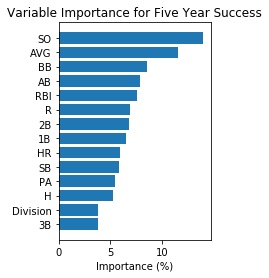

In [141]:
importance = model1.feature_importances_
importance2 = model2.feature_importances_
importance3 = model3.feature_importances_
importance4 = model4.feature_importances_

feature_importance = np.array((importance + importance2 + importance3 + importance4)/4 *100)

for i in range(len(features)):
    print (features[i], ": ", feature_importance[i])

sort = np.argsort(feature_importance)

pos = np.arange(sort.shape[0]) +0.5

plt.subplot(1,2,2)
plt.barh(pos, feature_importance[sort],align='center')
plt.yticks(pos, np.array(list(features))[sort])
plt.xlabel("Importance (%)")
plt.title("Variable Importance for Five Year Success")
plt.show()